In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import rnn, rnn_cell
import random
import time
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt

# using GRU one layer with 32 units
unit_name = "GRU"
mode = "32"

if mode == "32":
    rnn_size = 32
elif mode == "64":
    rnn_size = 64
elif mode == "128":
    rnn_size = 128
elif mode == "stack_32":
    rnn_size = 32

# define some hyperparameters

hm_epochs = 500
n_classes = 10
batch_size = 512
chunk_size = 1
num_chunks = 784

# define some placeholder

x = tf.placeholder('float', [None, num_chunks, chunk_size])
y = tf.placeholder('float')

# define the recurrent neural network

def recurrent_neural_network(x):
    # get the shape of x

    x_shape = tf.shape(x)[0]
    
    # define some weights for RNN
    rnn_sts_layer = {'weight':tf.Variable(tf.random_normal([rnn_size,1])),\
                     'bias':tf.Variable(tf.random_normal([1]))}

    # reshape the data
    before = tf.transpose(x,[1,0,2])
    before = tf.reshape(before,[-1,chunk_size])
    before = tf.split(before,num_or_size_splits=num_chunks,axis=0)

    # define the RNN cells
    if unit_name == "GRU":
        RNN_cell = tf.nn.rnn_cell.GRUCell(num_units=rnn_size)
    elif unit_name == "LSTM":
        RNN_cell = tf.nn.rnn_cell.LSTMCell(num_units=rnn_size)

    if mode == "stack_32":
        stack_rnn = []
        for i in range(3):
            stack_rnn.append(tf.nn.rnn_cell.GRUCell(num_units=rnn_size))
        RNN_cell = tf.contrib.rnn.MultiRNNCell(stack_rnn, state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(RNN_cell,before,dtype=tf.float32)

    # calculate the pixels
    pixels = []
    for this_pix in range(len(outputs)-1):
        pix = tf.add(tf.matmul(outputs[this_pix],rnn_sts_layer['weight']),rnn_sts_layer['bias'])    #batch_size * 1
        pixels.append(pix)
    
    # concat the pixels and output
    final_pixels = tf.concat(pixels,axis=0) 
    rnn_output = tf.reshape(final_pixels,[(num_chunks-1) * x_shape,-1])

    return rnn_output

# define the predictions
prediction = recurrent_neural_network(x)
prediction_sig = tf.nn.sigmoid(prediction)

# define losses optimizer and accuracy, the accuracy are different for pixel accuracy calculation
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(loss)
correct = tf.equal(tf.round(prediction_sig),y) 
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))


In [2]:
# a function to reshape data
def reshape_data(X_data):
    X_data = X_data.reshape([-1,num_chunks,chunk_size])
    y_data = X_data.transpose([1,0,2])[1:].reshape([-1, chunk_size])
    return X_data,y_data


In [3]:
# load the images
one_pixel_dataset = np.load('one_pixel_inpainting.npy')
one_pixel_images    = one_pixel_dataset[0]
one_pixel_gt_images = one_pixel_dataset[1]

four_pixel_dataset = np.load('2X2_pixels_inpainting.npy')
four_pixel_images    = four_pixel_dataset[0]
four_pixel_gt_images = four_pixel_dataset[1]

In [4]:
# this cell paint the one pixel dataset
with tf.Session() as sess:
    pred_list = []
    tf.train.Saver().restore(sess, '../models/pixel_{}_{}.checkpoint'.format(unit_name, mode))
    
    for imnage_num in range(len(one_pixel_images)):
        inpainting_loss_list = []
        # consider two cases for the missing pixel
        for choice in [0, 1]:
            this_image = one_pixel_images[imnage_num].copy()
            missing_index = np.where(this_image == -1)[0]
            this_image[missing_index] = choice
            this_guess_image = np.array([this_image])
            X_inpaint, y_inpaint = reshape_data(this_guess_image)
            X_GT, y_GT = reshape_data(one_pixel_gt_images)
            # a function to calculate the inpainting and ground truth loss
            def get_losses(sess):    
                inpainting_loss = sess.run(loss, feed_dict={x: X_inpaint, y: y_inpaint})
                GT_loss = sess.run(loss, feed_dict={x: X_GT, y: y_GT})
                return inpainting_loss, GT_loss
            inpainting_loss, GT_loss = get_losses(sess)
            inpainting_loss_list.append(inpainting_loss)
        
        # choose the case where the inpainting cross entropy loss was smallest
        best_choice = inpainting_loss_list.index(min(inpainting_loss_list))

        this_image = one_pixel_images[imnage_num].copy()
        missing_index = np.where(this_image == -1)[0]
        this_image[missing_index] = best_choice
        print("\r",imnage_num, best_choice, end="")
        
        #store it
        pred_list.append(this_image)
        
pred_list = np.array(pred_list)

# put it in the dataset
new_one_pixel_dataset = []
new_one_pixel_dataset.append(one_pixel_dataset[0])
new_one_pixel_dataset.append(one_pixel_dataset[1])
new_one_pixel_dataset.append(pred_list)
new_one_pixel_dataset = np.array(new_one_pixel_dataset)

INFO:tensorflow:Restoring parameters from ../models/pixel_GRU_32.checkpoint
 999 0

In [5]:
# this cell paint the four pixel dataset

with tf.Session() as sess:
    pred_list = []
    tf.train.Saver().restore(sess, '../models/pixel_{}_{}.checkpoint'.format(unit_name, mode))
    
    for imnage_num in range(len(four_pixel_images)):
        inpainting_loss_dict = {}
        # consider 16 cases for the missing pixel

        for i in range(16):
            choice = tuple([int(i) for i in list(('{0:04b}'.format(i)))])
            this_image = four_pixel_images[imnage_num].copy()
            missing_index = np.where(this_image == -1)[0]
            
            for c in range(4):
                this_image[missing_index[c]] = choice[c]
            
            this_guess_image = np.array([this_image])
            X_inpaint, y_inpaint = reshape_data(this_guess_image)
            X_GT, y_GT = reshape_data(four_pixel_gt_images)
            # a function to calculate the inpainting and ground truth loss
            def get_losses(sess):    
                inpainting_loss = sess.run(loss, feed_dict={x: X_inpaint, y: y_inpaint})
                GT_loss = sess.run(loss, feed_dict={x: X_GT, y: y_GT})
                return inpainting_loss, GT_loss
            inpainting_loss, GT_loss = get_losses(sess)
            inpainting_loss_dict[choice] = inpainting_loss
            
        # choose the case where the inpainting cross entropy loss was smallest
        best_choice = min(inpainting_loss_dict, key=inpainting_loss_dict.get)

        this_image = four_pixel_images[imnage_num].copy()
        missing_index = np.where(this_image == -1)[0]

        for c in range(4):
            this_image[missing_index[c]] = best_choice[c]
        
        print("\r",imnage_num, best_choice, end="")
        #store it
        pred_list.append(this_image)
        
pred_list = np.array(pred_list)

# put it in the dataset
new_four_pixel_dataset = []
new_four_pixel_dataset.append(four_pixel_dataset[0])
new_four_pixel_dataset.append(four_pixel_dataset[1])
new_four_pixel_dataset.append(pred_list)
new_four_pixel_dataset = np.array(new_four_pixel_dataset)

INFO:tensorflow:Restoring parameters from ../models/pixel_GRU_32.checkpoint
 999 (1, 1, 1, 1)

In [10]:
# store the data
np.save('one_pixel_inpainting_new.npy', new_one_pixel_dataset)
np.save('2X2_pixels_inpainting_new.npy',new_four_pixel_dataset)

In [11]:
# calculate the inpainting and ground truth cross entropy for one pixel
with tf.Session() as sess:
    pred_list = []
    tf.train.Saver().restore(sess, '../models/pixel_{}_{}.checkpoint'.format(unit_name, mode))
    
    X_inpaint, y_inpaint = reshape_data(new_one_pixel_dataset[2])
    X_GT, y_GT = reshape_data(new_one_pixel_dataset[1])
    def get_losses(sess):    
        inpainting_loss = sess.run(loss, feed_dict={x: X_inpaint, y: y_inpaint})
        GT_loss = sess.run(loss, feed_dict={x: X_GT, y: y_GT})
        return inpainting_loss, GT_loss
    inpainting_loss, GT_loss = get_losses(sess)
    print(inpainting_loss, GT_loss)

INFO:tensorflow:Restoring parameters from ../models/pixel_GRU_32.checkpoint
0.09592 0.096005


In [12]:
# calculate the inpainting and ground truth cross entropy for four pixels

with tf.Session() as sess:
    pred_list = []
    tf.train.Saver().restore(sess, '../models/pixel_{}_{}.checkpoint'.format(unit_name, mode))
    
    X_inpaint, y_inpaint = reshape_data(new_four_pixel_dataset[2])
    X_GT, y_GT = reshape_data(new_four_pixel_dataset[1])
    def get_losses(sess):    
        inpainting_loss = sess.run(loss, feed_dict={x: X_inpaint, y: y_inpaint})
        GT_loss = sess.run(loss, feed_dict={x: X_GT, y: y_GT})
        return inpainting_loss, GT_loss
    inpainting_loss, GT_loss = get_losses(sess)
    print(inpainting_loss, GT_loss)

INFO:tensorflow:Restoring parameters from ../models/pixel_GRU_32.checkpoint
0.0948396 0.0953245


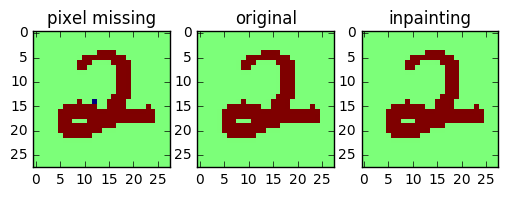

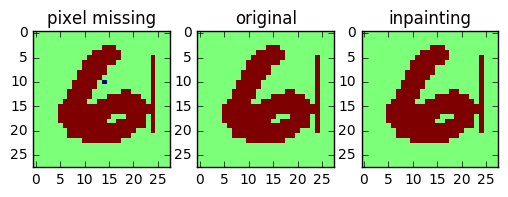

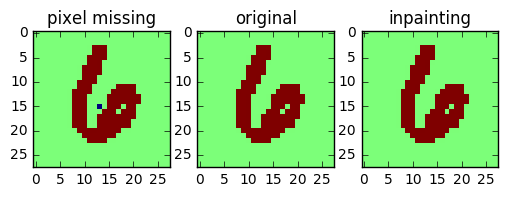

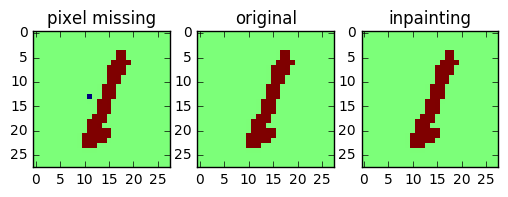

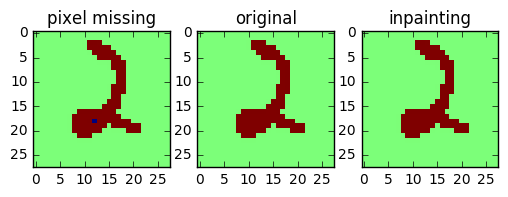

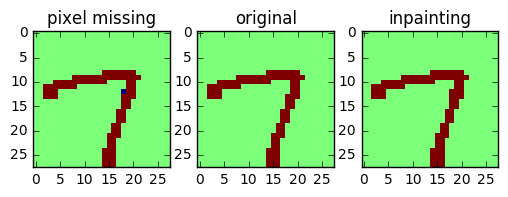

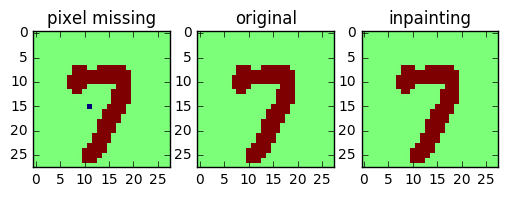

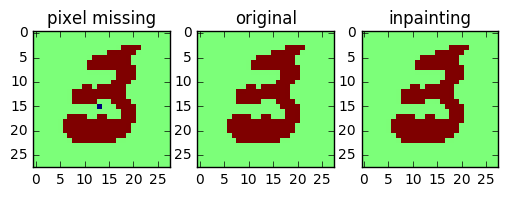

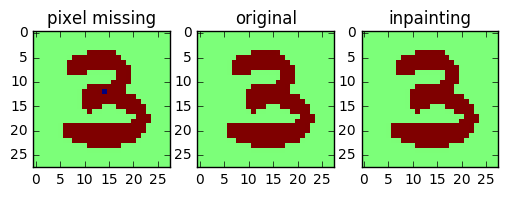

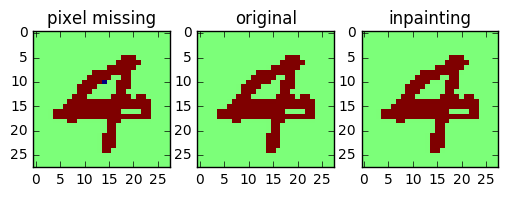

In [50]:
#visualize the inpainting for one pixel
for num in range(10):
    index = num
    plt.figure()
    plt.subplot(131)
    plt.title("pixel missing")
    plt.imshow(np.reshape(new_one_pixel_dataset[0][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.subplot(132)
    plt.title("original")
    plt.imshow(np.reshape(new_one_pixel_dataset[1][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.subplot(133)
    plt.title("inpainting")
    plt.imshow(np.reshape(new_one_pixel_dataset[2][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.show()


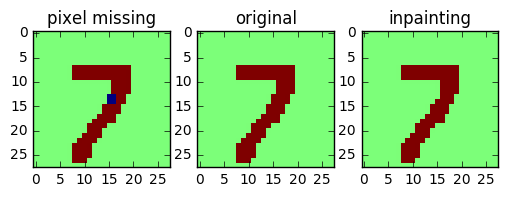

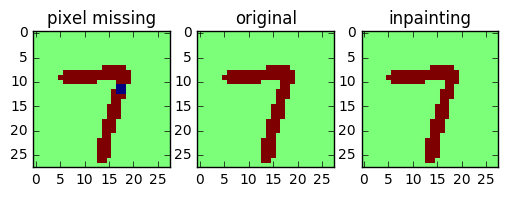

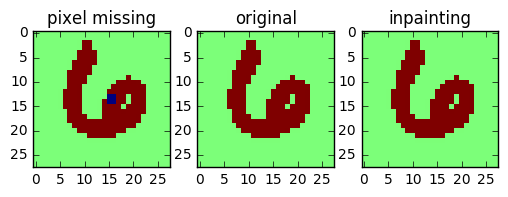

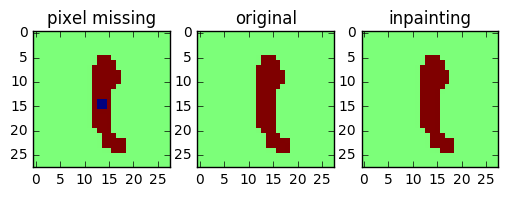

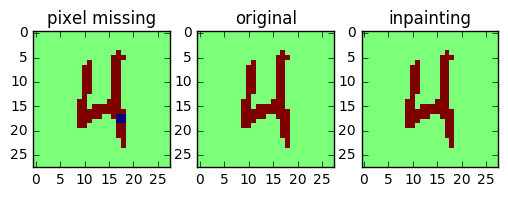

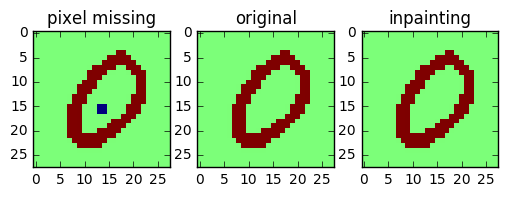

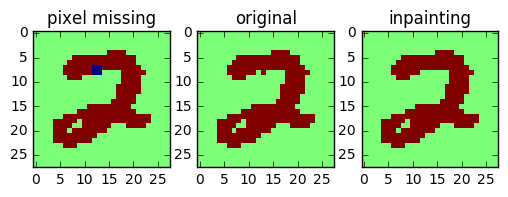

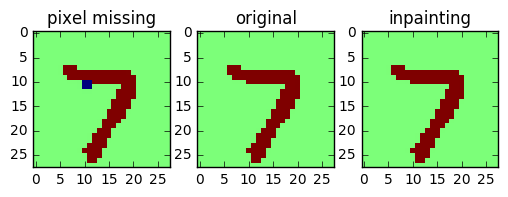

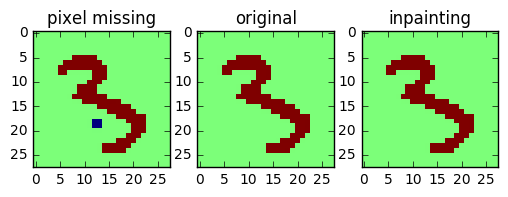

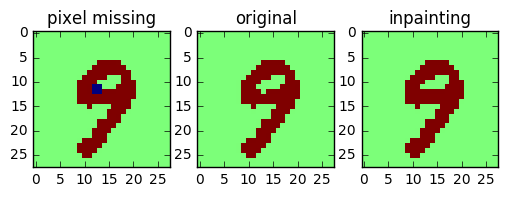

In [51]:
#visualize the inpainting for four pixel

for num in range(10):
    index = num
    plt.figure()
    plt.subplot(131)
    plt.title("pixel missing")
    plt.imshow(np.reshape(new_four_pixel_dataset[0][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.subplot(132)
    plt.title("original")
    plt.imshow(np.reshape(new_four_pixel_dataset[1][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.subplot(133)
    plt.title("inpainting")
    plt.imshow(np.reshape(new_four_pixel_dataset[2][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
    plt.show()


In [46]:
# a = """
# \\begin{figure}[H]
# """

# c = """
# \\end{figure}
# """

In [47]:
# plt.show()

In [48]:
# from pylab import savefig

# for num in range(10):
#     index = num
#     plt.figure()
#     plt.subplot(131)
#     plt.title("pixel missing")
#     plt.imshow(np.reshape(new_one_pixel_dataset[0][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
#     plt.subplot(132)
#     plt.title("original")
#     plt.imshow(np.reshape(new_one_pixel_dataset[1][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
#     plt.subplot(133)
#     plt.title("inpainting")
#     plt.imshow(np.reshape(new_one_pixel_dataset[2][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
# #     plt.show()
#     savefig("./Task_3_images/Task3_{}_one_pixel.png".format(num))
#     b = "\\caption{" + "Task 3 one pixel {}".format(num) + "}\n"
#     b += "\\includegraphics[scale=.8]{" + "Task3_{}_one_pixel.png".format(num) + "}\n\\centering"
#     print(a + b + c)

In [49]:
# for num in range(10):
#     index = num
#     plt.figure()
#     plt.subplot(131)
#     plt.title("pixel missing")
#     plt.imshow(np.reshape(new_four_pixel_dataset[0][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
#     plt.subplot(132)
#     plt.title("original")
#     plt.imshow(np.reshape(new_four_pixel_dataset[1][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
#     plt.subplot(133)
#     plt.title("inpainting")
#     plt.imshow(np.reshape(new_four_pixel_dataset[2][index],(28,28)), interpolation='None',vmin=-1, vmax=1)
# #     plt.show()
#     savefig("./Task_3_images/Task3_{}_four_pixel.png".format(num))
#     b = "\\caption{" + "Task 3 four pixel {}".format(num) + "}\n"
#     b += "\\includegraphics[scale=.8]{" + "Task3_{}_four_pixel.png".format(num) + "}\n\\centering"
#     print(a + b + c)